<a href="https://colab.research.google.com/github/adhamrait/uncategorized_projects/blob/main/AM160_P2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
from ipywidgets import interact
import torch
from google.colab import drive
from os import listdir
from scipy.io import netcdf_file
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import matplotlib.animation as animation
from matplotlib import rc
import random
rc('animation', html='jshtml')
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


# Data loading/cleaning

In [ ]:
raw_data = {}
normalized_data = []
data_directory = "/content/drive/My Drive/AM160_Final_data"
for filename in listdir(data_directory):
  year = int(filename.split('.')[0].split('z')[1])
  print(f"loading year {year}...")
  with netcdf_file(f'{data_directory}/{filename}', 'r') as f:
    raw_data[year] = f.variables['z'][:].copy()
  print(raw_data[year].shape)

loading year 1979...
(1460, 2, 91, 180)
loading year 1980...
(1464, 2, 91, 180)
loading year 1981...
(1460, 2, 91, 180)
loading year 1983...
(1460, 2, 91, 180)
loading year 1985...
(1460, 2, 91, 180)


In [ ]:
normalized_data = {}
for year, data in raw_data.items():
  mean = np.mean(data, axis=(0), keepdims=True)
  std = np.std(data, axis=(0), keepdims=True)
  normalized_data[year] = ((data - mean) / std).astype(float)

In [ ]:
training_years = [1979, 1980, 1981, 1983]
training_data = np.vstack([normalized_data[year] for year in training_years]).astype(float)
print(training_data.dtype)

float64


# Model

In [ ]:
class Decoder(nn.Module):
  def __init__(self, l_input_dim):
    super(Decoder, self).__init__()

    self.conv1 = nn.Conv2d(in_channels=2*l_input_dim, out_channels=32, kernel_size=3, stride=2, padding=1)
    self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2, padding=1)
    self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=2, padding=1)

    # After convolution, the spatial dimensions will be (l, 128 * 12 * 23)
    self.fc1 = nn.Linear(128 * 12 * 23+1, 1024)  # Flattened to (l, 128 * 12 * 23)
    self.fc2 = nn.Linear(1024, 1024)  # Added 1 for the scalar input

    self.fc_output = nn.Linear(1024, 2 * 91 * 180)

  def forward(self, x_image, x_scalar):
    x = F.relu(self.conv1(x_image))
    x = F.relu(self.conv2(x))
    x = F.relu(self.conv3(x))

    x = x.view(x.size(0), -1)  # Shape: (l, 128 * 11 * 22)

    x_scalar = x_scalar.view(x.size(0), -1)  # Make sure scalar is (l, 1)
    x = torch.cat((x, x_scalar), dim=1)

    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc_output(x)

    x = x.view(x.size(0), 2, 91, 180)

    return x

In [ ]:
class TimeSeriesDatasetMany(Dataset):
    def __init__(self, data, l):
        self.data = data
        self.l = l

    def __len__(self):
        return len(self.data) - self.l

    def __getitem__(self, idx):
        x_t = self.data[idx:idx+self.l]  # X(t)
        x_t_plus_1 = self.data[idx+self.l]  # X(t+1)
        return x_t, x_t_plus_1, idx % 1464

In [ ]:
def rk4_step(old, L):
  k1 = L(old)
  k2 = L(k1/2 + old)
  k3 = L(k2/2 + old)
  k4 = L(k3 + old)
  return old + 1/6*(k1 + 2*k2 + 2*k3 + k4)
def euler_step(old, L):
  return L(old) + old

# Trainers

In [ ]:
learning_rate = 1e-3
batch_size = 16
epochs = 20

In [ ]:
def train_model(l):
  time_series = TimeSeriesDatasetMany(training_data, l)
  training_loader = DataLoader(time_series, batch_size=batch_size, shuffle=True)

  model = Decoder(l).to(device)
  optimizer = optim.Adam(model.parameters(), lr=learning_rate)
  for epoch in range(epochs):
    model.train()
    train_loss = 0
    # Loop through batches of data
    for batch_idx, (previous_x, x, _) in enumerate(training_loader):
      x = x.to(device).float()
      previous_x = previous_x.squeeze(1).to(device).float()
      r = torch.rand((len(x), 1)).to(device).float().reshape(-1, 1)
      # print(x_0.shape)

      optimizer.zero_grad()

      # Forward pass
      if l > 1:
        out = model(previous_x.view(len(x), -1, 91, 180), r)
        loss = F.mse_loss(out, x-previous_x[:,-1])
      else:
        out = model(previous_x.view(len(x), -1, 91, 180), r)
        loss = F.mse_loss(out, x-previous_x)
      loss.backward()

      # Update weights
      optimizer.step()

      train_loss += loss.item()
      # if batch_idx % 100 == 0:
      #     print(f"Epoch {epoch + 1}/{epochs}, Batch {batch_idx}/{len(training_loader)}, Loss: {loss.item()/len(data)}")

    print(f"Epoch {epoch + 1}/{epochs}, Average Loss: {train_loss / len(training_loader.dataset)}")
  model.eval()
  return model

# l=1

In [ ]:
model_1 = train_model(1)

Epoch 1/20, Average Loss: 0.002883846008132913
Epoch 2/20, Average Loss: 0.002331542875410534
Epoch 3/20, Average Loss: 0.002117465268205274
Epoch 4/20, Average Loss: 0.0019727402741107633
Epoch 5/20, Average Loss: 0.0019067280318370609
Epoch 6/20, Average Loss: 0.0018826671366758507
Epoch 7/20, Average Loss: 0.0018378537882711714
Epoch 8/20, Average Loss: 0.0017865690479672528
Epoch 9/20, Average Loss: 0.0017314613191881103
Epoch 10/20, Average Loss: 0.0016872853521418944
Epoch 11/20, Average Loss: 0.0016469364278445644
Epoch 12/20, Average Loss: 0.0016075589856821117
Epoch 13/20, Average Loss: 0.001571253016680331
Epoch 14/20, Average Loss: 0.001534540230421381
Epoch 15/20, Average Loss: 0.0015090862864473188
Epoch 16/20, Average Loss: 0.0014998158110054148
Epoch 17/20, Average Loss: 0.0014612480182594047
Epoch 18/20, Average Loss: 0.0014340453660847206
Epoch 19/20, Average Loss: 0.0014118046491659812
Epoch 20/20, Average Loss: 0.0013929745502771222


## Evaluation

In [ ]:
eval_steps = 500
sample_number = 10

def ensemble_sample(l, step_function, steps, sample_number, model_ensemble):
  model_ensemble_time_series = [torch.from_numpy(normalized_data[1985][i]).float().to(device).unsqueeze(0) for i in range(l)]
  for t in range(steps):
    def L(y):
      ensemble = []
      prev = torch.stack(model_ensemble_time_series[-l:]).view( -1, 91, 180).unsqueeze(0)
      for _ in range(sample_number):
        # print(model_ensemble_time_series[-1].shape, t)
        r = torch.tensor([[random.random()]]).float().to(device)
        r = r.unsqueeze(0)
        output= model_ensemble(prev, r)
        ensemble.append(output.cpu().detach())
      return torch.mean(torch.stack(ensemble), axis=0).to(device)
    if t%200 == 0: print(t)
    model_ensemble_time_series.append(step_function(model_ensemble_time_series[-1], L).to(device))
  return  torch.stack(model_ensemble_time_series).squeeze(1).cpu()

In [ ]:
euler_1 = ensemble_sample(1, euler_step, eval_steps, sample_number, model_1)
rk4_1 = ensemble_sample(1, rk4_step, eval_steps, sample_number, model_1)

0
200
400
0
200
400


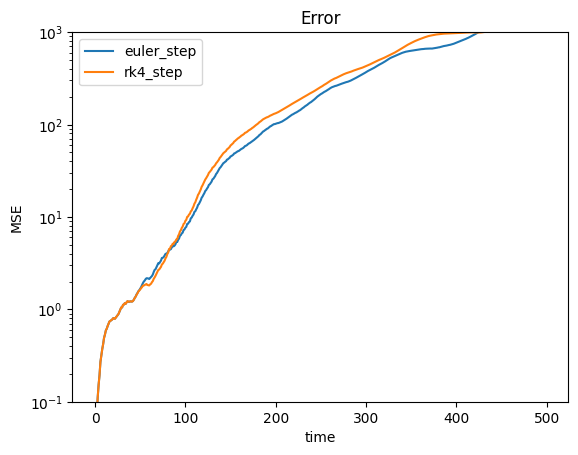

In [ ]:
def compare_error(expected, actual, T, label):
  # [print(expected[i].shape, actual[i].shape) for i in T]
  error =  [np.mean((expected[t]- actual[t])**2) for t in T]
  plt.plot(T,error, label=label)
  plt.xlabel("time")
  plt.ylabel("MSE")
  plt.yscale('log')
  plt.ylim((1e-1, 1e3))
compare_error(normalized_data[1985], euler_1.detach().numpy(), range(eval_steps), "euler_step")
compare_error(normalized_data[1985], rk4_1.detach().numpy(), range(eval_steps), "rk4_step")
plt.title("Error")
plt.legend()

# l=2

In [ ]:
model_2 = train_model(2)

Epoch 1/20, Average Loss: 0.002558655616626761
Epoch 2/20, Average Loss: 0.0020770830695620345
Epoch 3/20, Average Loss: 0.0019521997764563772
Epoch 4/20, Average Loss: 0.0019109253648850902
Epoch 5/20, Average Loss: 0.0018743172942194291
Epoch 6/20, Average Loss: 0.0018210003706628187
Epoch 7/20, Average Loss: 0.001760565809068901
Epoch 8/20, Average Loss: 0.001705683622087101
Epoch 9/20, Average Loss: 0.0016592474857097168
Epoch 10/20, Average Loss: 0.001614077084942331
Epoch 11/20, Average Loss: 0.001571178793057784
Epoch 12/20, Average Loss: 0.0015341084911521473
Epoch 13/20, Average Loss: 0.0015046329392794263
Epoch 14/20, Average Loss: 0.0014784435133581412
Epoch 15/20, Average Loss: 0.001451145218942252
Epoch 16/20, Average Loss: 0.0014296641473832787
Epoch 17/20, Average Loss: 0.0014026141717509634
Epoch 18/20, Average Loss: 0.001376435172752704
Epoch 19/20, Average Loss: 0.0013578460841621083
Epoch 20/20, Average Loss: 0.001350444694359247


## Evaluation

In [ ]:
euler_2 = ensemble_sample(2, euler_step, eval_steps, sample_number, model_2)
rk4_2 = ensemble_sample(2, rk4_step, eval_steps, sample_number, model_2)

0
200
400
0
200
400


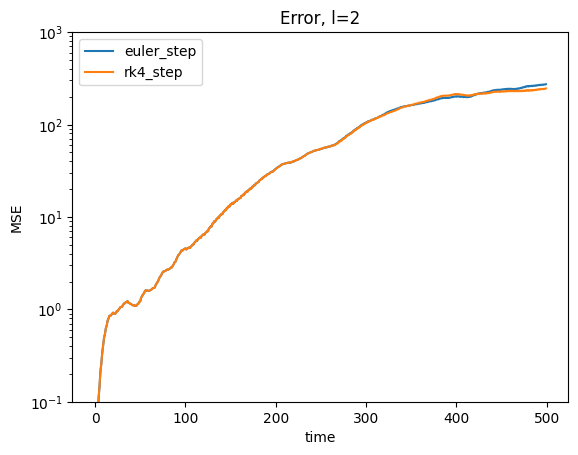

In [ ]:
compare_error(normalized_data[1985], euler_2.detach().numpy(), range(eval_steps), "euler_step")
compare_error(normalized_data[1985], rk4_2.detach().numpy(), range(eval_steps), "rk4_step")
plt.title("Error, l=2")
plt.legend()

# l=5

In [ ]:
model_5 = train_model(5)

Epoch 1/20, Average Loss: 0.002481121144962956
Epoch 2/20, Average Loss: 0.001985432498130228
Epoch 3/20, Average Loss: 0.0019219411238147535
Epoch 4/20, Average Loss: 0.0018846921821809586
Epoch 5/20, Average Loss: 0.0018472662666089365
Epoch 6/20, Average Loss: 0.0018058008144144367
Epoch 7/20, Average Loss: 0.0017662587581834966
Epoch 8/20, Average Loss: 0.0017120382064447193
Epoch 9/20, Average Loss: 0.0016581386281169425
Epoch 10/20, Average Loss: 0.001611531245257271
Epoch 11/20, Average Loss: 0.0015722410027642715
Epoch 12/20, Average Loss: 0.0015301271047462929
Epoch 13/20, Average Loss: 0.001496140505224696
Epoch 14/20, Average Loss: 0.0014629955118798622
Epoch 15/20, Average Loss: 0.0014338694773786667
Epoch 16/20, Average Loss: 0.0014450374600244805
Epoch 17/20, Average Loss: 0.0013951057595945544
Epoch 18/20, Average Loss: 0.001359731996966911
Epoch 19/20, Average Loss: 0.0013378300968992075
Epoch 20/20, Average Loss: 0.0013325699646677296


## Evaluation

In [ ]:
euler_5 = ensemble_sample(5, euler_step, eval_steps, sample_number, model_5)
rk4_5 = ensemble_sample(5, rk4_step, eval_steps, sample_number, model_5)

0
200
400
0
200
400


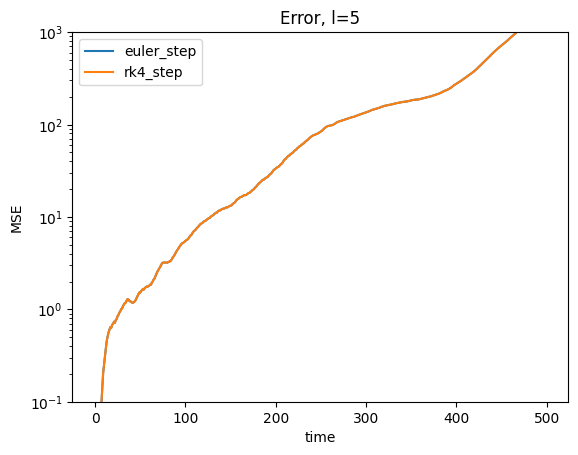

In [ ]:
compare_error(normalized_data[1985], euler_5.detach().numpy(), range(eval_steps), "euler_step")
compare_error(normalized_data[1985], euler_5.detach().numpy(), range(eval_steps), "rk4_step")
plt.title("Error, l=5")
plt.legend()